# Importes gerais / Instalações

In [ ]:
% matplotlib inline
!pip install kora
from IPython.display import clear_output 
clear_output()


import pandas as pd
import seaborn as sns
import numpy as np
import requests
import io
import os
import matplotlib.pyplot as plt

import kora.install.rdkit
from rdkit           import Chem
from rdkit.Chem      import AllChem
from rdkit.Chem      import Draw, Descriptors
from rdkit.Chem      import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from sklearn.model_selection import train_test_split

from keras           import regularizers
from keras.models    import Model
from keras.layers    import Input, LSTM, Dense, Concatenate 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import History, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam

#Get dataset from repository 
- Using original dataset instead of lastest review

(41127, 3)


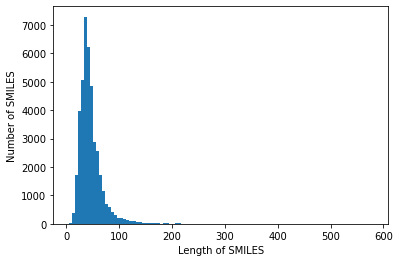

Percentage of instances with SMILES' length between 15 and 79: 0.9318938896588616
(38326, 3)


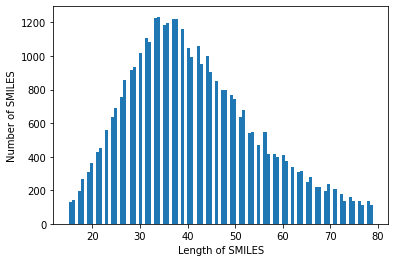

In [ ]:
def get_data_From_GitHub(url, df):
    if url is None:
        url ='https://github.com/GLambard/Molecules_Dataset_Collection/raw/master/originals/HIV.csv'
    df = pd.read_csv(io.StringIO(requests.get('https://github.com/GLambard/Molecules_Dataset_Collection/raw/master/originals/HIV.csv').content.decode('utf-8')), index_col = 0)
    df.reset_index(inplace=True)
    return df

def process_smiles_array(smiles_array):
  lengths = list()
  for i in smiles_array:
      lengths.append(len(i))
  return lengths

def Cut_Range_of_Smiles(df,save,plot,smiles_lengths):
    if save is True:
        df['smiles_length'] = smiles_lengths
    plt.hist(smiles_lengths, bins=100)
    plt.ylabel('Number of SMILES')
    plt.xlabel('Length of SMILES')
    if plot is True:
        plt.show()
    return df
def cut_Smile(df,Start,End,Prints=True):
    if Prints is True:
        print(df.shape)
    smiles_lengths = process_smiles_array(df['smiles'].values)
    df = Cut_Range_of_Smiles(df,True,Prints,smiles_lengths)
    length_range = (Start,End) #Range of the cut
    
    if Prints is True:
        filtered = filter(lambda x: length_range[0] <= x <= length_range[1], smiles_lengths)
        percentage = len(list(filtered)) / len(df['smiles'].values)
        print('Percentage of instances with SMILES\' length between %s and %s: %s' % (length_range[0], length_range[1], percentage))

    df = df[(df['smiles_length'] >= length_range[0]) & (df['smiles_length'] <= length_range[1])]
    df = df.drop('smiles_length', axis='columns')
    if Prints is True:
        print(df.shape)

    smiles_lengths = process_smiles_array(df['smiles'].values)
    df = Cut_Range_of_Smiles(df,False,Prints,smiles_lengths)
    return df

df = get_data_From_GitHub(None,None)
df = cut_Smile(df,15,79)

(41127, 3)


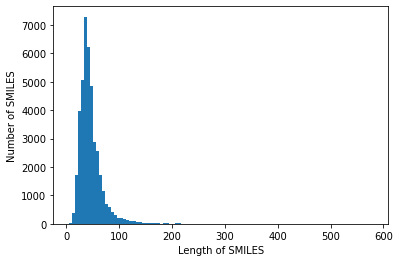

Percentage of instances with SMILES' length between 15 and 79: 0.9318938896588616
(38326, 3)


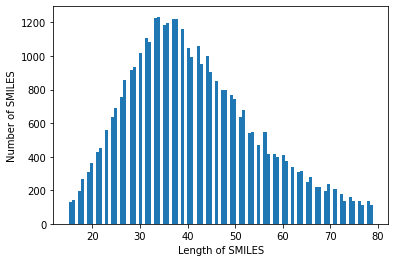

In [ ]:
df = get_data_From_GitHub(None,None)
df = cut_Smile(df,15,79)


# Seq2Seq Fingerprint
> informações utilizadas
> - https://github.com/XericZephyr/seq2seq-fingerprint/

Seguimento do seguinte post: [**Master your molecule generator: Seq2seq RNN models with SMILES in Keras** ](https://www.cheminformania.com/master-your-molecule-generator-seq2seq-rnn-models-with-smiles-in-keras/)

In [ ]:
# General Imports
%matplotlib inline
data = df

smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)
print(smiles_train.shape)
print(smiles_test.shape)
print(df.fillna('').astype(str).apply(lambda x:x.str.len()).mean())

(28744,)
(9582,)
smiles        41.376976
activity       2.000000
HIV_active     1.000000
dtype: float64


É necessário vectorizar os *SMILES* para um array.
para isto, um conjunto de caracteres é construido a partir de todos os caracteres encontrados nos *SMILES* (os de teste e de treino). 
Além disso, alguns caracteres são adicionaidos ao inicio e fim de cada *SMILE* para sinalizar quando a começou e acabou


*The stop character also work as padding to get the same length of all vectors, so that the network can be trained in batch mode. The character set is used to define two dictionaries to translate back and forth between index and character. The maximum length of the SMILES strings is needed as the RNN’s will be trained in batch mode, and is set to the maximum encountered + some extra.*

<!---The SMILES must be vectorized to one-hot encoded arrays. To do this a character set is built from all characters found in the SMILES string (both train and test). Also, some start and stop characters are added, which will be used to initiate the decoder and to signal when SMILES generation has stopped. The stop character also work as padding to get the same length of all vectors, so that the network can be trained in batch mode. The character set is used to define two dictionaries to translate back and forth between index and character. The maximum length of the SMILES strings is needed as the RNN’s will be trained in batch mode, and is set to the maximum encountered + some extra.-->

In [ ]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5
print(str(charset))
print(len(charset), embed)

{'t', 'n', 'i', 'T', 's', 'O', 'N', 'B', '7', '-', 'e', 'S', '(', '+', '1', '!', '[', 'R', 'l', 'H', '5', ')', 'Z', '.', 'g', '6', 'I', 'W', 'a', 'u', 'b', '#', ']', '=', 'M', '3', '4', 'E', 'K', 'A', 'c', 'U', 'C', 'p', 'r', 'V', 'o', 'P', '2', 'G', 'L', '8', 'F', 'd'}
54 84


*Afterwards the character set and dictionaries are used to set the necessary bits in the Numpy arrays. The result will be a “piano-roll” of each molecules SMILES string. The X data starts with !, but the output Y is offset by one character, and starts with the first character of the actual SMILES.*


Cc1nc(-c2nc(C)c(C(=O)NNC(=O)C[n+]3ccccc3)s2)sc1C(=O)NNC(=O)C[n+]1ccccc1.[Cl-]
(28744, 83, 54)


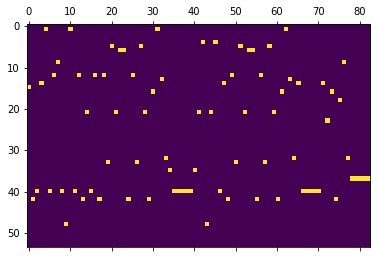

In [ ]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]

X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
print(smiles_train.iloc[1])
plt.matshow(X_train[1].T)
print(X_train.shape)

In [ ]:
#The int_to_char dictionary can be used to go from vectorized form back to a readable string, here with a joined list comprehension.
"".join([int_to_char[idx] for idx in np.argmax(X_train[1,:,:], axis=1)])

'!Cc1nc(-c2nc(C)c(C(=O)NNC(=O)C[n+]3ccccc3)s2)sc1C(=O)NNC(=O)C[n+]1ccccc1.[Cl-]EEEEE'

##modelo
Agora é o momento para construir o AutoEncoder, começando por calcular as 

---

dimenções dos vetores de treino e tambem o numero de LSTM cells para utilização do decoder e encoder

In [ ]:
def Encode_Build(input_shape,latent_dim,lstm_dim,unroll):
    encoder_inputs = Input(shape=input_shape)
    encoder        = LSTM(lstm_dim, return_state=True,unroll=unroll)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    states = Concatenate(axis=-1)([state_h, state_c])
    neck = Dense(latent_dim, activation="relu")
    neck_outputs = neck(states)
    return neck_outputs,encoder_inputs

def lstmDense (input_shape,lstm_dim,neck_outputs,encoder_inputs,unroll=False):
    #Import Keras objects
    
    decode_h        = Dense(lstm_dim, activation="relu")
    decode_c        = Dense(lstm_dim, activation="relu")
    state_h_decoded = decode_h(neck_outputs)
    state_c_decoded = decode_c(neck_outputs)
    encoder_states  = [state_h_decoded, state_c_decoded]
    decoder_inputs  = Input(shape=input_shape)
    decoder_lstm    = LSTM(lstm_dim,return_sequences=True,unroll=unroll)
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense   = Dense(output_dim, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    #Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    print (model.summary())
    return model
    
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
neck_outputs,encoder_inputs = Encode_Build(input_shape,128,128,False)
model = lstmDense(input_shape,128,neck_outputs,encoder_inputs)


Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 83, 54)]     0                                            
__________________________________________________________________________________________________
lstm_47 (LSTM)                  [(None, 128), (None, 93696       input_53[0][0]                   
__________________________________________________________________________________________________
concatenate_27 (Concatenate)    (None, 256)          0           lstm_47[0][1]                    
                                                                 lstm_47[0][2]                    
__________________________________________________________________________________________________
dense_93 (Dense)                (None, 128)          32896       concatenate_27[0][0]      

In [ ]:
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)
es = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 5, verbose = True, mode ='auto')
opt=Adam(lr=0.05) #Default 0.001 origem 0.005
model.compile(optimizer=opt, loss='categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.fit([X_train,X_train],Y_train,
                    epochs=100,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr, es],
                    validation_data=([X_test,X_test],Y_test))

Epoch 1/100
113/113 [==============================] - 6s 32ms/step - loss: 1.7443 - val_loss: 0.6914
Epoch 2/100
113/113 [==============================] - 3s 23ms/step - loss: 0.6446 - val_loss: 0.5675
Epoch 3/100
113/113 [==============================] - 3s 24ms/step - loss: 0.5464 - val_loss: 0.5153
Epoch 4/100
113/113 [==============================] - 3s 24ms/step - loss: 0.5044 - val_loss: 0.4882
Epoch 5/100
113/113 [==============================] - 3s 24ms/step - loss: 0.4759 - val_loss: 0.4663
Epoch 6/100
113/113 [==============================] - 3s 24ms/step - loss: 0.4552 - val_loss: 0.4465
Epoch 7/100
113/113 [==============================] - 3s 24ms/step - loss: 0.4384 - val_loss: 0.4357
Epoch 8/100
113/113 [==============================] - 3s 24ms/step - loss: 0.4272 - val_loss: 0.4315
Epoch 9/100
113/113 [==============================] - 3s 24ms/step - loss: 0.4226 - val_loss: 0.4274
Epoch 10/100
113/113 [==============================] - 3s 24ms/step - loss: 0.416

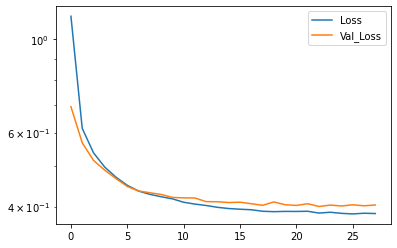

In [ ]:
#!pip install pickle5
#import pickle
#pickle.dump(h.history, open("Blog_history.pickle","w"))
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

# Nova secção

In [ ]:
fail = 0
for i in range(100):
    v = model.predict([X_test[i:i+1], X_test[i:i+1]]) #Can't be done as output not necessarely 1
    idxs = np.argmax(v, axis=2)
    pred=  "".join([int_to_char[h] for h in idxs[0]])[:-1]
    idxs2 = np.argmax(X_test[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])[1:]
    if true != pred:
        print(true, pred)
        fail=fail+1
print("Failed"+str(fail))
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)
smiles_to_latent_model.save("Blog_simple_smi2lat.h5")

condição: 100


In [ ]:
latent_input = Input(shape=(latent_dim,))
#reuse_layers
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.save("Blog_simple_lat2state.h5")

In [ ]:
#Last one is special, we need to change it to stateful, and change the input shape
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = LSTM(128,
                    return_sequences=True,
                    unroll=False,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

#Transfer Weights
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.save("Blog_simple_samplemodel.h5")
sample_model.summary()

In [ ]:
#Transfer Weights
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.save("Blog_simple_samplemodel.h5")
sample_model.summary()

In [ ]:
molno = 5
latent_mol = smiles_to_latent_model.predict(X_test[molno:molno+1])
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))
print(sorti[0:10])
print(smiles_test.iloc[sorti[0:8]])
Draw.MolsToGridImage(smiles_test.iloc[sorti[0:8]].apply(Chem.MolFromSmiles), molsPerRow=5, useSVG=False)